## Building a Multilayer Perceptron



Let's follow the lecture and build a multilayer perceptron to approximate the function $\theta(x)$ in our variational inference model $$\mathrm{Bernoulli}(z|\theta(x))$$ with the following structure

* 2 input nodes
* 2 internal features computed using ReLu activation
* 1 output feature with sigmoid activation that 

From Ex3, we had already the following code ready

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def linear(X,pars):
    out = X @ pars[:2].T + pars[2]
    grad_pars = np.column_stack([X,np.ones(len(X))])
    return out,grad_pars

def sigmoid(x):
    out = 1/(1+np.exp(-x))
    grad = out*(1-out)
    return out,grad.reshape(-1,1)

def theta_perceptron(X,pars):
    feature1,grad_linear1 = linear(X,pars[0:3])
    activation1,grad_sigmoid1 = sigmoid(feature1)
    return activation1, grad_sigmoid1*grad_linear1

* Write a function `relu(x)` that produces the relu activation function and its gradient.
* make sure the gradient is returned as a shape (N,1)
* plot it for the range: `x = np.linspace(-5,5,1001)`

In [56]:
def relu(x):
    out = np.where(x < 0, np.zeros_like(x),x)
    grad = np.where(x < 0, np.zeros_like(x),np.ones_like(x))
    return out,grad.reshape(-1,1)

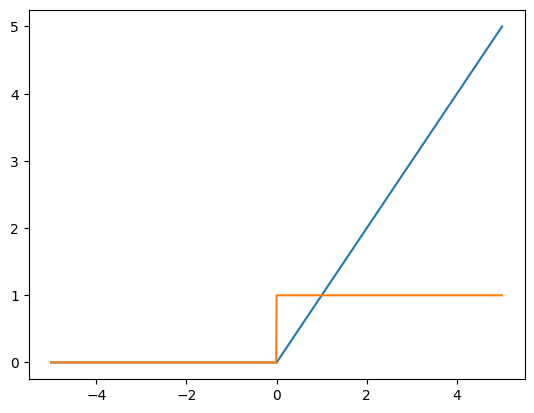

In [57]:
xi = np.linspace(-5,5,1001)
r,g = relu(xi)
plt.plot(xi,r)
plt.plot(xi,g)

Write a function `multilayer_perceptron(X,pars)` that takes 9 parameters (3 for each artificial neurons: 2 weights and 1 bias) that can compute the $\theta(x)$ prediction for many input points at once (batched computation)

In [58]:
def multilayer_perceptron(X,pars):
    feature1,grad_f1 = linear(X,pars[0:3])
    feature2,grad_f2 = linear(X,pars[3:6])
    activation1,grad_r1 = relu(feature1)
    activation2,grad_r2 = relu(feature2)
    hidden = np.column_stack([activation1,activation2])
    output_feature,grad_f3 = linear(hidden,pars[6:9])
    theta,grad_sig = sigmoid(output_feature)
    return theta

Use this function to plot the contour of the multilayer perceptron

```
def plot_contour(func,pars):
    grid = np.mgrid[-5:5:101j,-5:5:101j]
    X = np.swapaxes(grid,0,-1).reshape(-1,2)
    out = func(X,pars)
    out = np.swapaxes(out.reshape(101,101),0,-1)
    plt.contour(grid[0],grid[1],out)
```

Try for example parameter vectors: `np.array([1,0,0,0,1,0,1,1,0])` or what every you like.

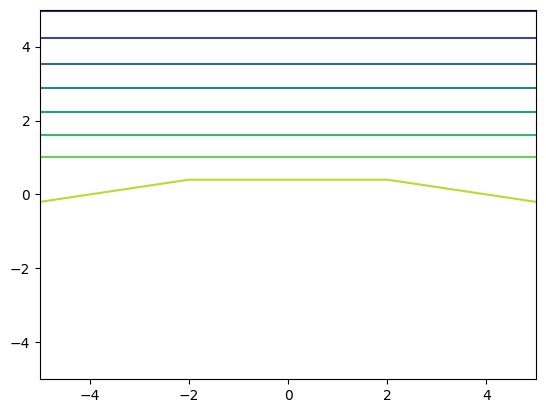

In [59]:
def plot_contour(func,pars):
    grid = np.mgrid[-5:5:101j,-5:5:101j]
    X = np.swapaxes(grid,0,-1).reshape(-1,2)
    out = func(X,pars)
    out = np.swapaxes(out.reshape(101,101),0,-1)
    plt.contour(grid[0],grid[1],out)
    
plot_contour(multilayer_perceptron,np.array([-.2,1,0.0,.2,1,0.0,-.1,-.1,0]))

Now comes the hard part!

We want to compute gradients for this function

$$
\vec{a} = [\;\mathrm{ReLU}(\mathrm{Lin}(\vec{x},\phi_1))\;,\;\mathrm{ReLU}(\mathrm{Lin}(\vec{x},\phi_2))\;]\\
a_2 = \sigma(\mathrm{Lin}(\vec{a},\phi_3))\\
$$

To compute the gradient we need to also have the gradients $\frac{\partial \mathrm{Lin}}{\partial \vec{x}}$

* Write a new function that also outputs the partial derivatives with respect to $\vec{x}$
* Hint: the output shape of `grad_x` should be (1,3)!

```
def linear(X,pars):
   ...
   return out,grad_pars,grad_x
```

In [60]:
def linear(X,pars):
    out = X @ pars[:2].T + pars[2]
    grad_pars = np.column_stack([X,np.ones(len(X))])
    grad_x = pars
    return out,grad_pars, grad_x.reshape(1,-1)

With this in hadn you can now carefully piece back the gradients together.

We can start with the function like this

```python
def multilayer_perceptron(X,pars):
    feature1,grad_f1,_ = linear(X,pars[0:3])
    feature2,grad_f2,_ = linear(X,pars[3:6])
    activation1,grad_r1 = relu(feature1)
    activation2,grad_r2 = relu(feature2)
    hidden = np.column_stack([activation1,activation2])
    output_feature,grad_f3,grad_x = linear(hidden,pars[6:9]) #here is the new gradient!
    theta,grad_sig = sigmoid(output_feature)
    return theta
```

* Try to work out what the 9-dimensional gradient vector looks like for $\nabla_\phi \theta(x,\phi)$
* Hint 1: the gradient should have the shape `(N,9)`
* Hint 2: The following would be a correct result

```
Xtest = np.array([[1.0,1.0]])
pars = np.array([0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2])
multilayer_perceptron(Xtest,pars)

value: [0.9552123]
gradient: [[0.02994724 0.05989447 0.02994724 0.02738033 0.06845082 0.03422541
  0.03422541 0.08556353 0.04278176]]
``` 


In [61]:
def multilayer_perceptron(X,pars):
    feature1,grad_f1,_ = linear(X,pars[0:3])
    feature2,grad_f2,_ = linear(X,pars[3:6])
    activation1,grad_r1 = relu(feature1)
    activation2,grad_r2 = relu(feature2)
    hidden = np.column_stack([activation1,activation2])
    output_feature,grad_f3,grad_x = linear(hidden,pars[6:9])
    theta,grad_sig = sigmoid(output_feature)
    
    grad1 = grad_sig*grad_x[:,0]*grad_r1*grad_f1
    grad2 = grad_sig*grad_x[:,1]*grad_r2*grad_f2
    grad3 = grad_sig*grad_f3
    grad = np.concatenate([grad1,grad2,grad3],axis=-1)
    return theta,grad

In [62]:
Xtest = np.array([[1.0,2.0]])
pars = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
value,grad = multilayer_perceptron(Xtest,pars)
print(f'value: {value}')
print(f'gradient: {grad}')

value: [0.9552123]
gradient: [[0.02994724 0.05989447 0.02994724 0.03422541 0.06845082 0.03422541
  0.03422541 0.08556353 0.04278176]]


## Training the Perceptron

We can adapt the learning code from Exercise 3 to learn the multi-layer perceptron.

We can get some interesting datasets from the `scikit-learn` package

* Install scikit-learn via `pip install scikit-learn`
* Use the following data-generating function and plot the data

```
def generate_data(N):
    import sklearn.datasets as skld
    return skld.make_moons(N, noise = 0.2)
```

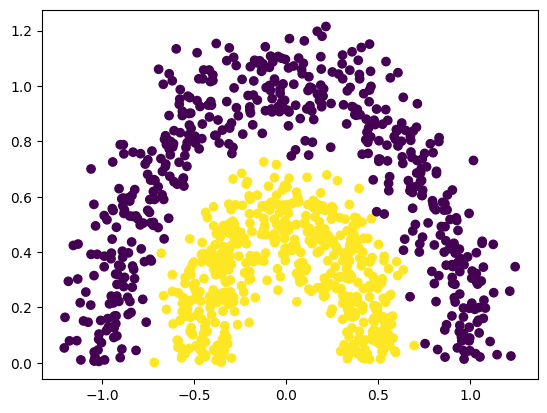

In [63]:
def generate_data(N):
    import sklearn.datasets as skld
    X,z = skld.make_circles(N, noise = 0.1, factor=0.5)
    filt =  (X[:,1] > 0)
    return X[filt],z[filt]

X,z = generate_data(2000)
plt.scatter(X[:,0],X[:,1],c = z)

We can now adapt our training code from exercise 3 (take some time to go through it, but nothing fundamental changed) and train out multilayer perceptron!


In [64]:
def loss(z,theta):
    out = np.where(z==1,-np.log(theta),-np.log(1-theta))
    grad = np.where(z==1,-1/theta,-1/(1-theta)*(-1))
    return out,grad.reshape(-1,1)

def empirical_risk(X,z,theta_func,pars):
    theta,grad_theta = theta_func(X,pars)
    loss_val,grad_loss = loss(z,theta)
    grad1 = grad_loss*grad_theta
    grad = np.concatenate([grad1], axis=-1)
    return loss_val.mean(axis=0),grad.mean(axis=0),theta

def plot(X,z,theta_func,pars):
    grid = np.mgrid[-5:5:101j,-5:5:101j]
    Xi = np.swapaxes(grid,0,-1).reshape(-1,2)   
    _,_,zi = empirical_risk(Xi,np.zeros(len(Xi)),theta_func,pars)
    zi = zi.reshape(101,101).T
    plt.contour(grid[0],grid[1],zi, levels = np.linspace(0,1,21))
    plt.scatter(X[:,0],X[:,1],c = z)
    plt.xlim(-2,2)
    plt.ylim(-2,2)

def learn(data,pars,theta_func, nsteps = 5000):
    X,z = data
    for i in range(nsteps):
        val,grad,_ = empirical_risk(X,z,theta_func,pars)
        pars = pars - 0.01*grad
        if i % (nsteps//4) == 0:
            print(val,pars)
            plot(X,z,theta_func,pars)
            plt.gcf().set_size_inches(3,3)
            plt.show()
    return pars

# Try Learning

Try learning on a dataset of 1000 samples and initialize the parameters with 

`pars = np.array([0,1,0,0,1,0,.1,.1,0])`

* Note: the point to see here is that non-linear decision boundaries are learned. 
* The learning itself, depending on the initialization might or might not be super-convincing
* Try executing this multiple times to try out different initializations
* Ultimately, we will need to add more & more neurons, but as you see the gradient calculation is painful!

0.6794165383367701 [-1.00012263e-01  1.00005905e+00  4.99958098e-01  1.00001241e+00
  1.00005001e+00 -3.87144362e-05 -1.00393212e-01 -1.00624196e-01
  4.19022710e-04]


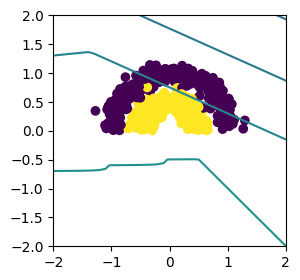

0.5946865491646388 [-0.20559643  1.16511509  0.32444602  1.01951993  1.16698216 -0.25308009
 -0.505072   -0.68957571  0.60043549]


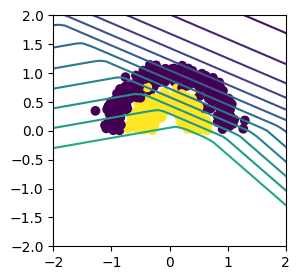

0.48132407009675093 [-0.54137605  1.43845005 -0.03208171  1.15156677  1.41488514 -0.60809308
 -1.05513495 -1.30694789  1.03780781]


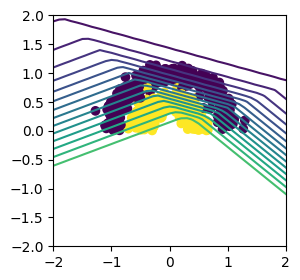

0.3514012477904336 [-1.10747414  1.62133278 -0.46756127  1.47002408  1.66957951 -0.79048578
 -1.68040522 -1.89308728  1.41282351]


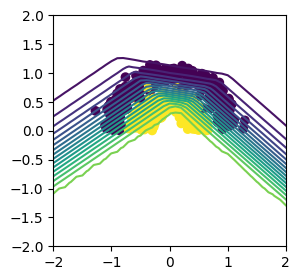

array([-1.57466046,  1.79297434, -0.76142814,  1.75161004,  1.88413455,
       -0.97229715, -2.24142743, -2.36092278,  1.83026931])

In [65]:
learn(generate_data(1000),np.array([-.1,1,0.5,1,1,0,-.1,-.1,0]) ,multilayer_perceptron)


# Going to many Nodes

In [66]:
N_NODES = 10
def linear(X,pars):
    out = X @ pars[:-1].T + pars[-1]
    grad_pars = np.column_stack([X,np.ones(len(X))])
    grad_x = pars[:-1]
    return out,grad_pars, grad_x.reshape(1,-1)

def many_nodes_mlp(X,pars):
    activations = []
    grads = []
    for i in range(N_NODES):
        feature, grad_f,_ = linear(X,pars[3*i:3*(i+1)])
        activation,grad_r = relu(feature)
        activations.append(activation)
        grads.append([grad_r,grad_f])
    
    hidden = np.column_stack(activations)
    output_feature,grad_f3,grad_x = linear(hidden,pars[-(N_NODES+1):])
    theta,grad_sig = sigmoid(output_feature)
    
    grad_components = []
    for i in range(N_NODES):
        grad = grad_sig*grad_x[:,i]*grads[i][0]*grads[i][1]
        grad_components.append(grad)
    grad3 = grad_sig*grad_f3
    grad = np.concatenate(grad_components+[grad3],axis=-1)
    return theta,grad

def generate_data(N):
    import sklearn.datasets as skld
    X,z = skld.make_circles(N, noise = 0.1, factor=0.5)
    return X,z

1.9146818236153613 [-0.52247383 -1.03949535 -0.088597    0.41815781  1.19058903 -0.15105
 -0.97789564 -1.29707865 -0.55560321  1.14470958 -2.31405516  1.11251446
 -0.06715503 -0.89665467 -0.39145126 -0.61144904  0.19897024  0.22833417
 -0.05849689 -0.53828308 -0.09012146  0.5676371   1.7388086  -0.49621348
 -0.20198918  1.61658488  0.15810453  0.33126441  0.66770095  0.57899697
 -0.35259708  0.06037028 -1.11347296  2.30837226  1.00128799 -0.8442782
  0.20316738  0.90037511 -0.34325212  0.5464052  -0.06826356]


C:\Users\julia\AppData\Local\Temp\ipykernel_16196\3653339230.py:2: RuntimeWarning: divide by zero encountered in log
  out = np.where(z==1,-np.log(theta),-np.log(1-theta))
C:\Users\julia\AppData\Local\Temp\ipykernel_16196\3653339230.py:3: RuntimeWarning: divide by zero encountered in divide
  grad = np.where(z==1,-1/theta,-1/(1-theta)*(-1))
C:\Users\julia\AppData\Local\Temp\ipykernel_16196\3653339230.py:9: RuntimeWarning: invalid value encountered in multiply
  grad1 = grad_loss*grad_theta


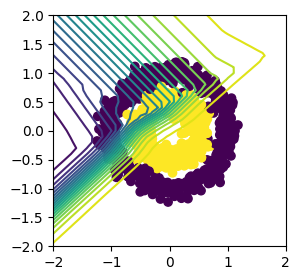

0.5537160337527852 [-0.25747303 -1.32804097 -0.07787687  0.5054147   1.23540359 -0.16808951
 -0.82601268 -1.77116572 -0.52414572  0.11176226 -1.54189306  0.79164421
 -0.0683092  -0.62713889 -0.68128651 -0.63907268  0.20416518 -0.1819693
 -0.08195067 -0.48276961 -0.14228967  0.38955162  1.50454988 -0.68111686
 -0.04144392  1.75303841 -0.06134049 -0.13880598  0.65189841  0.72416401
 -0.77399196 -0.44565974 -1.54471072  0.66576746  0.95000184 -0.85447487
  0.00674097  0.31348363 -0.71927432  0.61344579 -0.10332309]


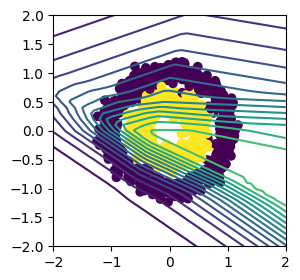

0.4628757270565604 [-0.02983619 -1.47371961 -0.08594842  0.72227956  1.27510573 -0.19757418
 -0.95701002 -1.87874224 -0.62245734 -0.10742512 -1.31370412  1.09941098
 -0.06840532 -0.61812494 -0.689098   -0.96720368  0.31156443 -0.15790758
 -0.07798881 -0.4866858  -0.14353163  0.36723828  1.45801453 -0.72225259
 -0.08506755  1.87967275 -0.20062932 -0.39092854  0.65497518  0.83825434
 -0.97113918 -0.75851714 -1.76778889  0.61035005  0.94973497 -1.14209341
 -0.05972325  0.03617745 -1.00966686  0.83194223  0.02990084]


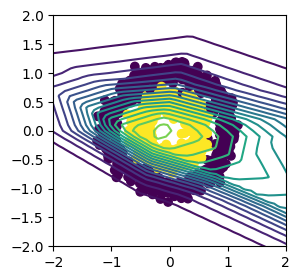

0.362877002642515 [ 0.36593161 -1.60378459 -0.0695417   1.0685709   1.24525063 -0.21500574
 -1.20322331 -1.91204374 -0.67585533 -0.25355442 -1.21871371  1.23430225
 -0.0686281  -0.61368687 -0.6929107  -1.40602465  0.42768337 -0.15267887
 -0.06640217 -0.49622719 -0.14676587  0.37288259  1.46707425 -0.71398087
 -0.25503244  1.97424426 -0.34165025 -0.58570671  0.65371622  0.96542247
 -1.21398474 -1.06180344 -1.96277854  0.70674403  0.94964695 -1.55884264
 -0.11051239 -0.14188709 -1.23213982  1.05360024  0.12483543]


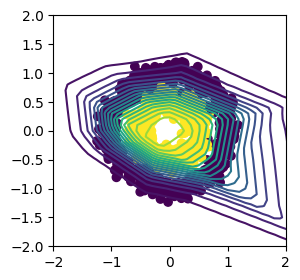

array([ 0.76822902, -1.71954409, -0.09421594,  1.42750621,  1.18897231,
       -0.22399965, -1.47116492, -1.95064702, -0.66109237, -0.3465074 ,
       -1.18045198,  1.35528291, -0.06876779, -0.61113583, -0.69508721,
       -1.8260813 ,  0.53151427, -0.18169579, -0.05307952, -0.51139124,
       -0.14677861,  0.39187696,  1.49434936, -0.69020978, -0.41000177,
        2.08175356, -0.40854832, -0.71444842,  0.66272141,  1.13645031,
       -1.52273099, -1.37487579, -2.16758588,  0.88134133,  0.94960251,
       -1.97406741, -0.16095404, -0.28647423, -1.45171566,  1.28405472,
        0.25315595])

In [67]:
learn(generate_data(1000),np.random.normal(size = (3*N_NODES+N_NODES+1)), many_nodes_mlp)